<a href="https://colab.research.google.com/github/YuichH/ML/blob/main/Kaggle/HousePrices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#共通


In [ ]:
import sys
# Google colab環境であるか判定
if 'google.colab' in sys.modules:
    # マウントを行う
    from google.colab import drive
    drive.mount('/content/drive')
else:
    print("Not Google Colab")

Mounted at /content/drive


In [ ]:
# Google Colab. やJupyter Lab.でプロットするためには，以下を実行する．
import plotly.io as pio
pio.renderers.default = "colab"

#invite people for the Kaggle party
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import numpy as np
from scipy.stats import norm
from scipy.stats import norm, skew #for some statistics
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
%matplotlib inline

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

from subprocess import check_output

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#パラメータ
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type=int, default=100)
parser.add_argument("--batch_size", type=int, default=128)
# parser.add_argument("--lr", type=float, default=0.001)
parser.add_argument("--model_name", default="House Prices")
parser.add_argument("--work_dir", default="/content/drive/MyDrive/Kaggle/House Prices/")
parser.add_argument("--input_dir", default="/content/drive/MyDrive/Kaggle/House Prices/")
parser.add_argument("--model_dir", default="/content/drive/MyDrive/Kaggle/House Prices/")
opt = parser.parse_args(args=[])
print(opt)

Namespace(n_epoch=100, batch_size=128, model_name='House Prices', work_dir='/content/drive/MyDrive/Kaggle/House Prices/', input_dir='/content/drive/MyDrive/Kaggle/House Prices/', model_dir='/content/drive/MyDrive/Kaggle/House Prices/')


#Stacked Regressions : Top 4% on LeaderBoard
Score: 0.12002

https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard

In [ ]:
train = pd.read_csv(opt.input_dir + "train.csv")
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [ ]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
test = pd.read_csv(opt.input_dir + "test.csv")
test.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [ ]:
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


##ID分割

In [ ]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape))
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


##外れ値

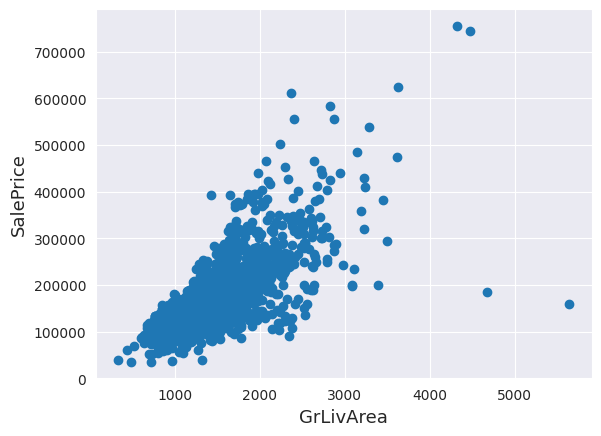

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

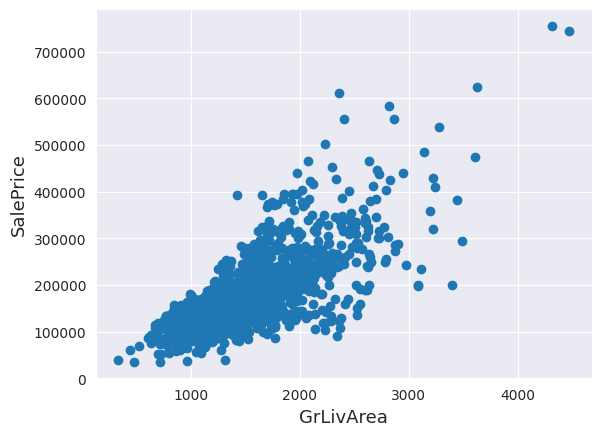

In [ ]:
#Deleting outliers 面積が広くて、価格の安い2件を削除
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

##目的変数


 mu = 180932.92 and sigma = 79467.79



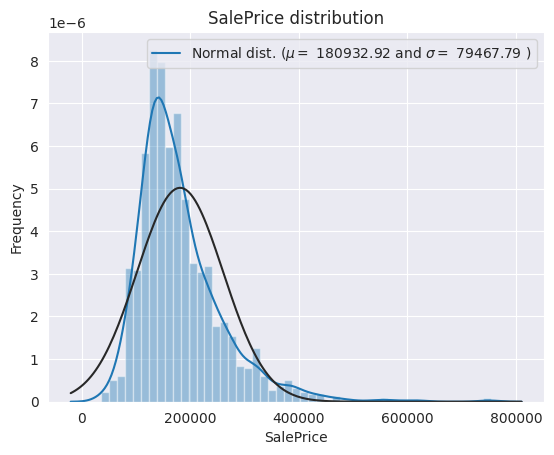

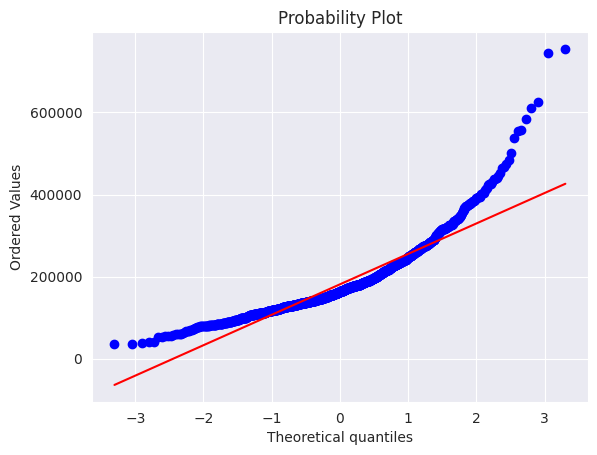

In [ ]:
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()


 mu = 12.02 and sigma = 0.40



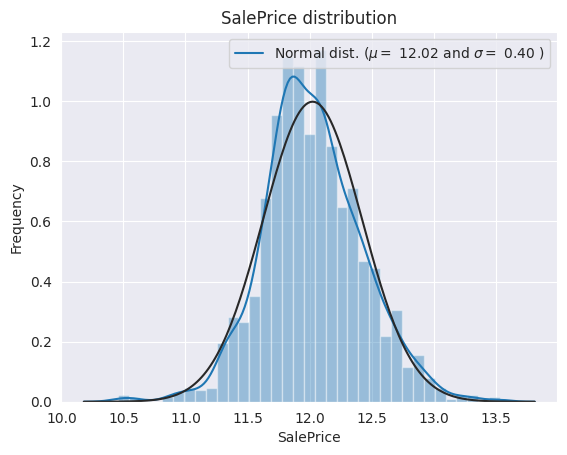

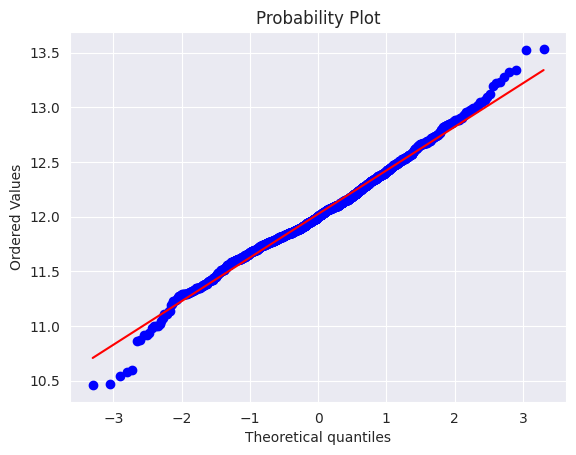

In [ ]:
# log変換
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

##特徴量エンジニアリング

###trainとtestを同時編集

In [ ]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


###欠損値

In [ ]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100 #データフレームの各列について欠損値の割合
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30] #割合が0の列を取り除き、欠損値の割合が多い順にソートし、先頭から30件まで
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na}) #欠損値の割合を表すデータフレームを作成
missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageFinish,5.451
GarageQual,5.451
GarageCond,5.451
GarageYrBlt,5.451


Text(0.5, 1.0, 'Percent missing data by feature')

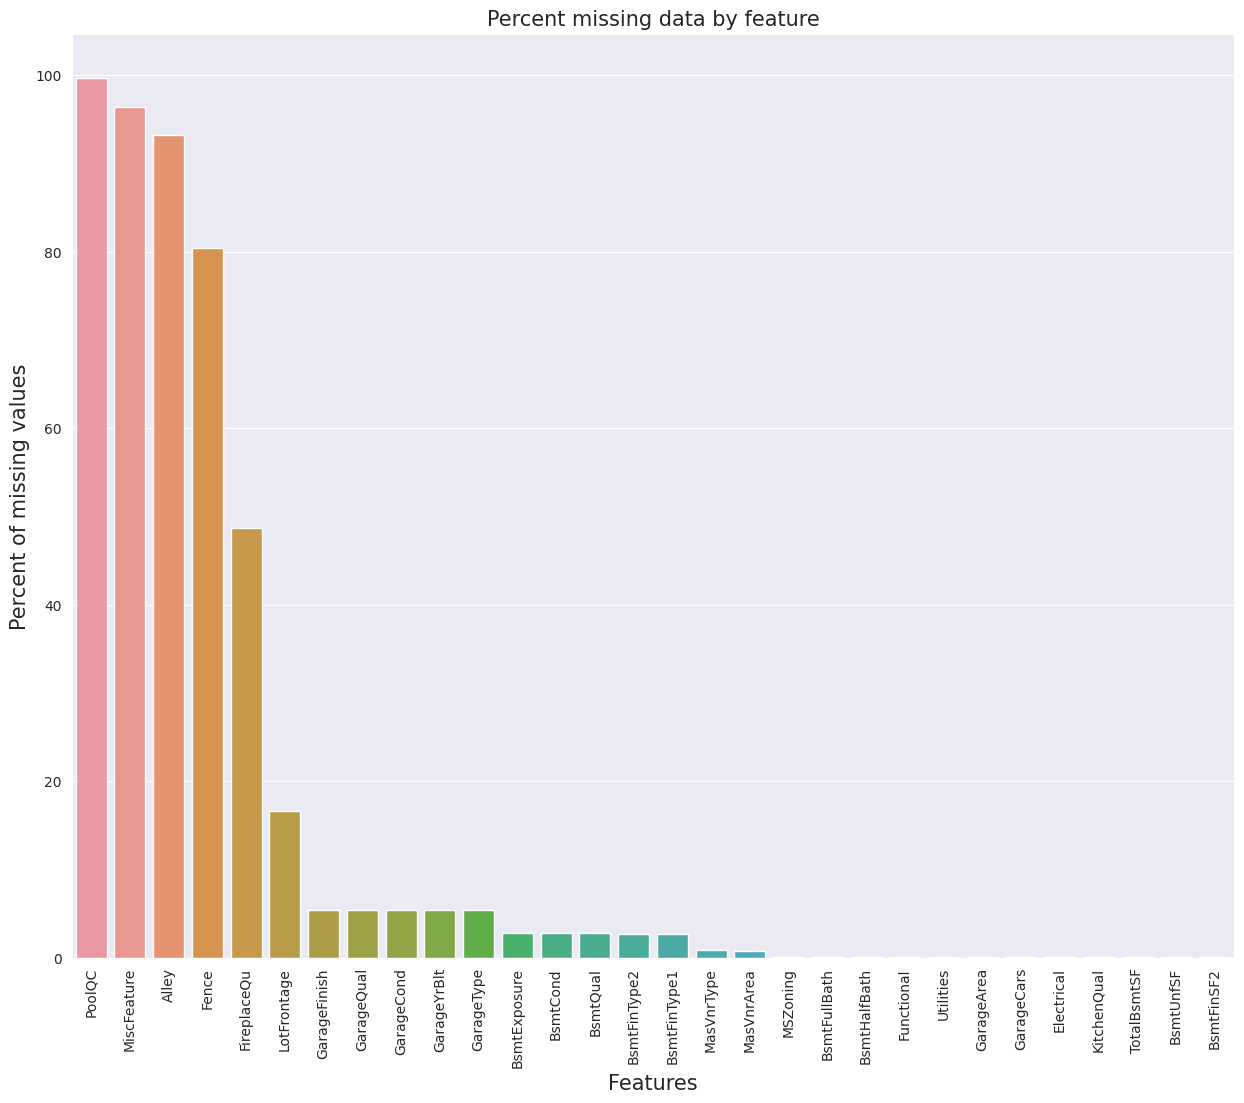

In [ ]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation=90) #x軸のラベルを垂直方向に90度回転(ラベルが長い場合に、文字が重ならないようにするため)
sns.barplot(x=all_data_na.index, y=all_data_na) #x引数に列名、y引数に欠損値の割合
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

###相関

<Axes: >

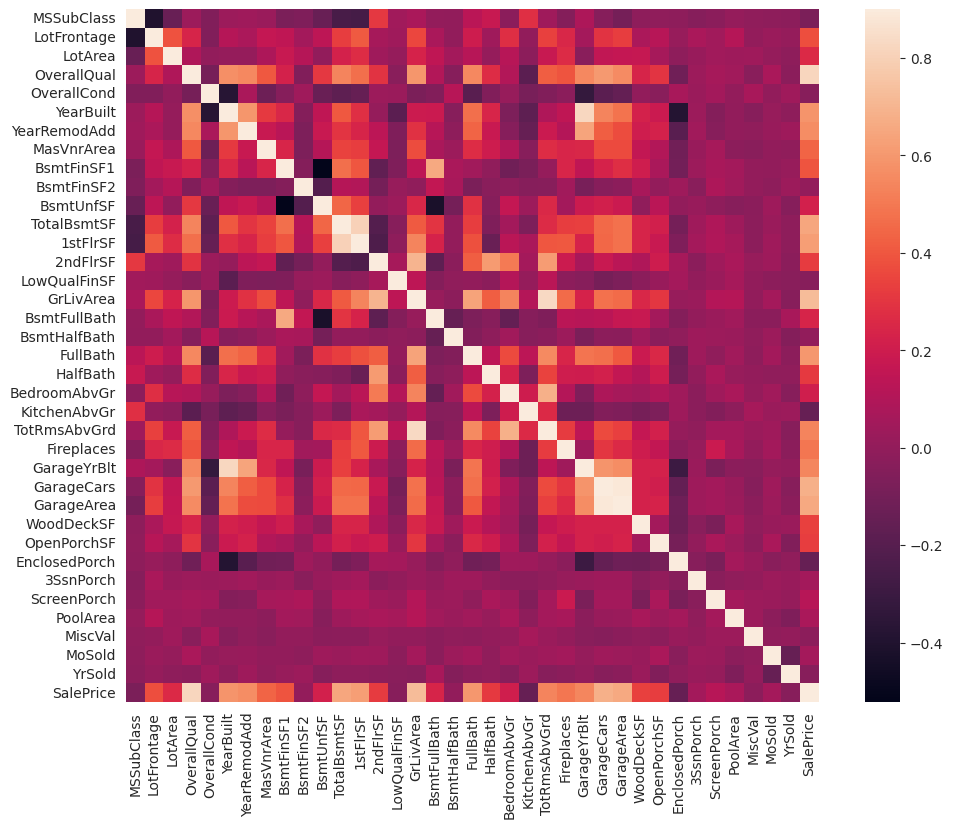

In [ ]:
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

###欠損値の補完

PoolQC : データの説明によると、NAは「プールなし」を意味します。これは、欠損値の割合が大きい（99％以上）ことと、一般的にプールがない家が多いことを考えると、理にかなっていると思います。

In [ ]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

MiscFeature : NAは「その他の機能なし」を意味します。

In [ ]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

Alley : データの説明では、NAは "路地へのアクセスなし "を意味する。

In [ ]:
all_data["Alley"] = all_data["Alley"].fillna("None")

Fence：データの説明では、NAは "フェンスなし "を意味する。

In [ ]:
all_data["Fence"] = all_data["Fence"].fillna("None")

FireplaceQu : データの説明では、NAは "暖炉がない "という意味だそうです。

In [ ]:
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

LotFrontage : 家の敷地に接続されている各ストリートの面積は、近隣の他の家と同様の面積を持つ可能性が高いため、近隣のLotFrontageの中央値で欠損値を埋めることができます。

In [ ]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
# groupby：Neighborhood 列の値をグループ化
# transform：Neighborhood 列の値のグループごとに、中央値を算出し、新しいLotFrontage 列を作成
# lambda：LotFrontage 列に対して、欠損値がある場合には中央値で埋める

GarageType、GarageFinish、GarageQual、GarageCond : 欠損データをNoneで置換する。

In [ ]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

GarageYrBlt、GarageArea、GarageCars：欠損データを0に置き換える（ガレージがない＝そのガレージには車がないため）。

In [ ]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath : 地下室がないため欠損値はゼロと思われます。

In [ ]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

BsmtQual、BsmtCond、BsmtExposure、BsmtFinType1、BsmtFinType2 ：これら全ての地下室に関するカテゴリー的特徴について、NaNは地下室がないことを示す。

In [ ]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

MasVnrAreaとMasVnrType： NA は、これらの住宅に石造りのベニヤがないことを意味する可能性が高い。面積は0、タイプはNoneと記入することができる。

In [ ]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

MSZoning (The general zoning classification) : 'RL'が圧倒的に多い値です。だから、欠落している値を'RL'で埋めることができる。

In [ ]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])    #mode() メソッドは、シリーズオブジェクトの中で最も出現頻度が高い値を返します。[0] は、最頻値のリストから最初の要素を取り出すために使います。

Utilities:このカテゴリ特徴では、1件の「NoSeWa」と2件の「NA」を除き、すべてのレコードが「AllPub」である。NoSewa」の家はトレーニングセットに含まれているため、この特徴は予測モデリングに役立ちません。そのため、安全に削除することができます。

In [ ]:
all_data = all_data.drop(['Utilities'], axis=1)

Functional :データ説明によると、NAは典型的なものを意味する

In [ ]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

Electrical :NA値が1つあります。この機能はほとんど「SBrkr」であるため、欠損値にはそれを設定することができます。

In [ ]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

KitchenQual： NA値は1つだけで、Electricalと同様、KitchenQualの欠損値には最も頻度の高い「TA」を設定しました。

In [ ]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

Exterior1st と Exterior2nd : ここでも、Exterior1 と Exterior2 の両方が1つだけ欠落している値を持っています。最も一般的な文字列で代用することにします。

In [ ]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

SaleType ： 最も頻度の高い "WD "を再度記入する。

In [ ]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

MSSubClass : Na は、No building class を意味する可能性が高い。欠損値をNoneに置き換えることができる

In [ ]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

残りの欠損値

In [ ]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


##さらに特徴量エンジニアリング

カテゴリーであるいくつかの数値変数を変換する

In [ ]:
# apply() メソッドを使って、シリーズオブジェクト all_data['MSSubClass'] の全ての要素に対して関数を適用
# str() 関数を使って、数値型の MSSubClass 列を文字列型に変換します。
# 文字列型に変換することで、モデルがこの列をカテゴリ変数として認識
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

ラベル その順序集合に情報を含む可能性のあるいくつかのカテゴリー変数をエンコードする。

In [ ]:
# カテゴリカルな特徴量が数値に変換
# LabelEncoder は順序特徴量の場合には良い結果を出しますが、名義特徴量の場合にはうまく変換できない
# 名義特徴量の場合は One-Hot Encoding などを使う
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1',
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond',
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder()
    lbl.fit(list(all_data[c].values))
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


一つ重要な特徴を追加する<br>
面積に関する特徴は、住宅価格を決定する上で非常に重要であるため、各住宅の地下室、1階、2階の面積の合計を1つの特徴として追加しました。

In [ ]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

歪度な特徴量

In [ ]:
# 数値型の特徴量のみを抽出
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
# lambda 関数を使って、各数値型特徴量の歪度（skewness）を計算、データ分布が正規分布からどの程度ずれているかを示す指標です。正規分布の場合には歪度は0
# 計算された歪度を降順にソートして、skewed_feats に格納
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
# 計算された歪度を含む DataFrame を作成し、表示します。
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


歪んだ特徴量のボックスCox変換<br>
対数変換は、データが右に偏っている（正の歪度を持つ）場合に使用されます。この場合、データに対数を適用することで、分布を左にシフトし、より正規分布に近づけることができます。

Box-Cox 変換は、対数変換よりも柔軟で、データの歪度が正であるか、負であるかに関係なく、任意の正の値の lambda を使用して変換することができます。<br>
lambda=0 の場合、Box-Cox 変換は対数変換と等価になります。
<br>また、 lambda=1 の場合は、単純なスケーリングになります。

In [ ]:
# 歪度の絶対値が0.75を超える特徴量のみを選択
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
# Box-Cox 変換が必要な特徴量のリストを skewed_features に格納
skewed_features = skewness.index
# Box-Cox 変換における λ の値を定義。データによって最適な値が異なります。
lam = 0.15
# 各特徴量について、boxcox1p 関数を使って Box-Cox 変換を適用
#  y = (x**λ - 1)/λ    (λ ≠ 0)
#  y = log(1+x)          (λ = 0)
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)

# 特徴量を対数変換する方法です。どちらの変換方法が最適かは、データによって異なるため、両方の変換方法を試して最適なものを選択する必要があります。
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 59 skewed numerical features to Box Cox transform


ダミーカテゴリカル特徴量の取得

In [ ]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


新しいtrain、testデータ

In [ ]:
train = all_data[:ntrain]
test = all_data[ntrain:]

<Axes: >

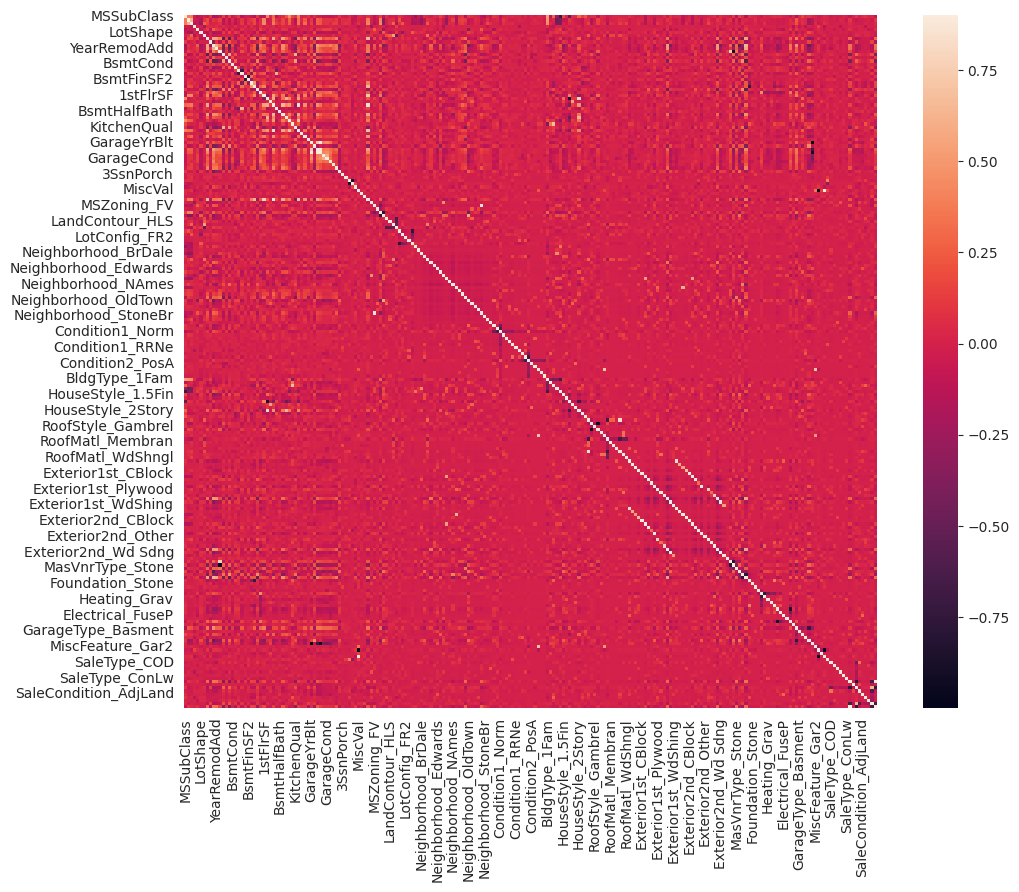

In [ ]:
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

##モデリング

In [ ]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

###交差検証を定義する
Sklearnのcross_val_score関数を使用します。しかし、この関数にはshuffle属性がないので、クロスバリデーションの前にデータセットをシャッフルするために、1行のコードを追加する。

In [ ]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    # 各フォールドでモデルを訓練し、残りのフォールドで予測を行い、MSE を算出
    # 各フォールドの MSE の平均値の平方根 (RMSE) を返します。
    # 目的変数の値を対数変換しているため、評価指標には RMSLE (Root Mean Squared Logarithmic Error) が使用されます。
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

###ベースモデル

LASSO回帰：このモデルは外れ値に対して非常に敏感である可能性があります。そこで、外れ値に対してより頑健にする必要がある。そのために、sklearnのRobustscaler()メソッドをパイプラインで使用する。

scikit-learnのPipelineを使用して、データのスケーリングとLasso回帰モデルの作成を同時に行うものです。<br>
RobustScaler()は、各特徴量の中央値を0、四分位範囲を1に変換するスケーリング関数であり、外れ値に対してロバストな方法を採用しています。<br>
Lasso(alpha =0.0005, random_state=1)は、L1正則化を採用した線形回帰モデルであり、alphaパラメーターによって正則化の強度を調整することができます。random_stateは、乱数生成器の状態を指定するために使用されます。

In [ ]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

Elastic Net回帰：<br>
RobustScaler()：データをスケーリングするための前処理手法。ロバストスケーリングにより、外れ値の影響を受けにくいデータに変換することができます。<br>
ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3)：ElasticNet回帰モデルを定義します。alphaは正則化パラメータであり、モデルの複雑度を調整するために使用されます。l1_ratioはL1正則化とL2正則化の比率を指定します。random_stateは乱数のシード値を指定します。ElasticNet()関数は、このモデルを定義するための関数です。<br>make_pipeline()関数は、このモデルに前処理手法を追加するための関数です。

In [ ]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

カーネルリッジ回帰：リッジ回帰をカーネルトリックにより拡張したモデルで、非線形回帰を行うことができます。KernelRidge の主なパラメータには、正則化パラメーター alpha、カーネル関数 kernel、ポリノミアルカーネルの次数 degree、および定数項 coef0 があります。

In [ ]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

勾配ブースティング回帰 ：
n_estimators：決定木の数（デフォルト値：100）<br>
learning_rate：各決定木の寄与度を制御するパラメータで、小さな値であるほどモデルの更新がゆっくりになり、決定木の数が多くなることが必要になる（デフォルト値：0.1）<br>
max_depth：各決定木の最大の深さ（デフォルト値：3）<br>
max_features：各決定木で考慮する特徴量の数を制限するためのパラメータ（デフォルト値：'None'、つまりすべての特徴量が考慮される）<br>
min_samples_leaf：各葉ノードで必要な最小サンプル数（デフォルト値：1）<br>
min_samples_split：内部ノードを分割するために必要な最小サンプル数（デフォルト値：2）<br>
loss：損失関数の種類（デフォルト値：'ls'、つまり最小二乗誤差）。'huber'を指定することで、外れ値に対してロバストな回帰を行うことができます。<br>
random_state：再現性のための乱数生成器のシード（デフォルト値：None）

In [ ]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state =5)

XGBoost<br>
colsample_bytree：各木の特徴量を使用する割合<br>
gamma：木の複雑さに対するペナルティの大きさ<br>
learning_rate：各木の影響を小さくするための学習率<br>
max_depth：決定木の最大深さ<br>
min_child_weight：葉ノードに必要なサンプル数の最小値<br>
n_estimators：決定木の数<br>
reg_alpha：L1正則化の強さ<br>
reg_lambda：L2正則化の強さ<br>
subsample：各木の学習データをサンプリングする割合<br>
random_state：再現性のための乱数シード<br>
nthread：並列処理を行うスレッド数（-1は全てのスレッドを使うことを意味する）<br>

In [ ]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,
                             learning_rate=0.05, max_depth=3,
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

LightGBM <br>
objective: 目的関数。回帰問題を解くためには、"regression"を指定します。<br>
num_leaves: 決定木の最大の葉の数。大きくすると、より複雑なモデルが作られますが、過学習のリスクも高まります。<br>
learning_rate: 各ステップでの学習率。値が小さいほど、モデルの学習が緩やかになりますが、学習に必要な反復回数が増えます。<br>
n_estimators: 使用する決定木の数。<br>
max_bin: ヒストグラムのバケットの数。大きい値を指定すると、より高い精度が得られますが、処理時間も増えます。<br>
bagging_fraction: 学習データのサブサンプルの割合。値が小さいほど、より多様な決定木が作られますが、過学習のリスクも高まります。<br>
bagging_freq: バギングを行う頻度。<br>
feature_fraction: 各決定木の特徴量のサブサンプルの割合。<br>
feature_fraction_seed: 特徴量のサブサンプルをランダムに選択する際の乱数のシード。<br>
bagging_seed: バギングを行う際の乱数のシード。<br>
min_data_in_leaf: 葉に必要な最小サンプル数。小さくすると、より複雑なモデルが作られますが、過学習のリスクも高まります。<br>
min_sum_hessian_in_leaf: 葉に必要な最小の二次微分の和。小さくすると、より複雑なモデルが作られますが、過学習のリスクも高まります。

In [ ]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

###ベースモデル scores

In [ ]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1115 (0.0074)



In [ ]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1116 (0.0074)



In [ ]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1153 (0.0075)



In [ ]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1167 (0.0083)



In [ ]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[00:13:23] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[00:13:32] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[00:13:40] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[00:13:48] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[00:13:57] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

Xgboost score: 0.1172 (0.0050)



In [ ]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6

###スタッキングモデル
最もシンプルな積層方法：ベースモデルの平均化
私たちは、ベースモデルを平均化するというこのシンプルなアプローチから始めます。私たちのモデルでscikit-learnを拡張し、カプセル化とコードの再利用（継承）を平均化するために、新しいクラスを構築します。

Averaged base models class

In [ ]:
# 複数のモデルを引数として取り、それらのトレーニング、予測、および平均化を行う
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models

    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]

        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self

    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

ENet, GBoost, KRR and lasso

In [ ]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1087 (0.0077)



###シンプルでないStacking ：メタモデルの追加

この方法では、平均化されたベースモデル上にメタモデルを追加し、これらのベースモデルのアウトオブフォールズ予測値を用いてメタモデルを学習する。

訓練部分の手順は以下の通りである：

全トレーニングセットを2つの不連続なセット（ここではtrainと.holdout ）に分割する。

最初のパートで複数のベースモデルをトレーニングする（訓練する）。

これらのベースモデルを第2部（ホールドアウト）でテストする

3)の予測（アウトオブフォールズ予測と呼ばれる）を入力とし、正解（ターゲット変数）を出力として、メタモデルと呼ばれる上位の学習器を学習する。

最初の3つのステップは、繰り返し行われる。例えば、5回積み重ねる場合、まず学習データを5回に分割します。そして、5回の反復を行います。各反復では、4つのフォールドでベースモデルを学習し、残りのフォールド（ホールドアウトフォールド）で予測します。

つまり、5回の反復の後、データ全体がフォールド外の予測に使われ、ステップ4でメタモデルを訓練するための新しい特徴として使われることを確認する。

予測部分については、テストデータに対するすべてのベースモデルの予測値を平均化し、メタモデルで最終的な予測を行うためのメタ特徴として使用します。

https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard?scriptVersionId=1955054&cellId=130

Stacking averaged Models Class

In [ ]:
# モデルのアンサンブルを行うために使用。基本モデルとメタモデルが使用されます。
# まず、基本モデルをクローンしてデータに適合させ、予測を作成します。
# その後、これらの予測をメタモデルに適合させます。
# 最後に、テストデータを使用してメタモデルによって予測された平均値を返します。このようにして、基本モデルのアンサンブルを使用してモデルの性能を向上させることができます。
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)

        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred

        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self

    #Do the predictions of all base models on the test data and use the averaged predictions as
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

Stacking Averaged models Score

In [ ]:
#Enet KRRとGboostを平均化し、メタモデルとしてlassoを追加しています。
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1081 (0.0073)


StackedRegressor、XGBoost、LightGBMのアンサンブル

StackedRegressorに、XGBoostとLightGBMを追加する。<br>
まず、rmsle評価関数を定義します。

In [ ]:
# 実際の値と予測値の両方を対数変換した上で、平均二乗誤差（MSE）を計算し、その平方根を返す関数です。
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

StackedRegressor

In [ ]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.07839506096665937


XGBoost:

In [ ]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

[00:21:14] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

0.0790460201201611


LightGBM:

In [ ]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
0.07169383068991829


In [ ]:
print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.07548697935004024


Ensemble prediction:

In [ ]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

Submission

In [ ]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv(opt.input_dir + 'submission.csv',index=False)

#Comprehensive data exploration with Python
Score: 0.56086

https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python/notebook


In [ ]:
df_train = pd.read_csv(opt.input_dir + "train.csv")
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [ ]:
df_train['SalePrice'].describe()

count     1460.000
mean    180921.196
std      79442.503
min      34900.000
25%     129975.000
50%     163000.000
75%     214000.000
max     755000.000
Name: SalePrice, dtype: float64

最低価格はゼロより大きい

##Relationship with numerical variables

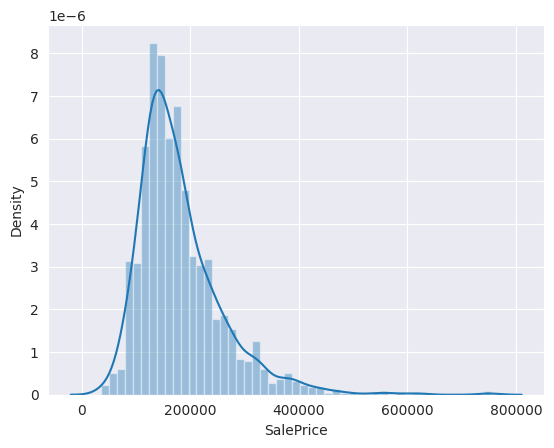

In [ ]:
sns.distplot(df_train['SalePrice']);

正規分布から外れている。<br>
歪度がかなり高い。<br>
ピークがある

In [ ]:
print("Skewness(歪度): %f" % df_train['SalePrice'].skew())
print("Kurtosis(尖度): %f" % df_train['SalePrice'].kurt())

Skewness(歪度): 1.882876
Kurtosis(尖度): 6.536282


歪度：分布が正規分布からどれだけ歪んでいるかを表す統計量で、左右対称性を示す指標<br>
　　　「左に偏った」分布のときには正の値<br>
　　　「右に偏った」分布のときには負の値<br>
尖度：正規分布からどれだけ尖っているかを表す統計量で、山の尖り度と裾の広がり度<br>
　　　尖った分布（データが平均付近に集中し、分布の裾が重い）のときには正の値<br>
　　　扁平な分布（データが平均付近から散らばり、分布の裾が軽い）のときには負の値

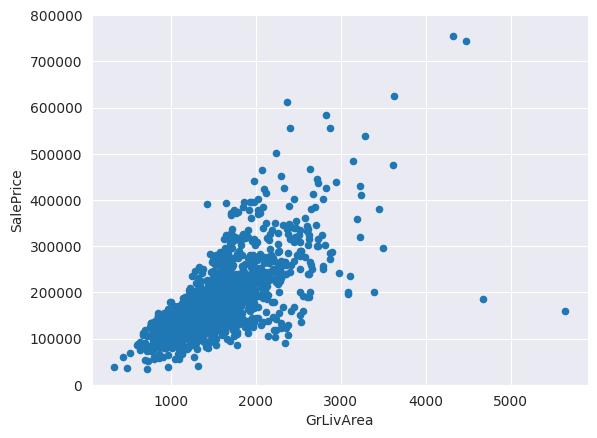

In [ ]:
#GrLivArea： 地上階（グラウンド）居住面積平方フィート
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

→Salepriceと直線的な関係

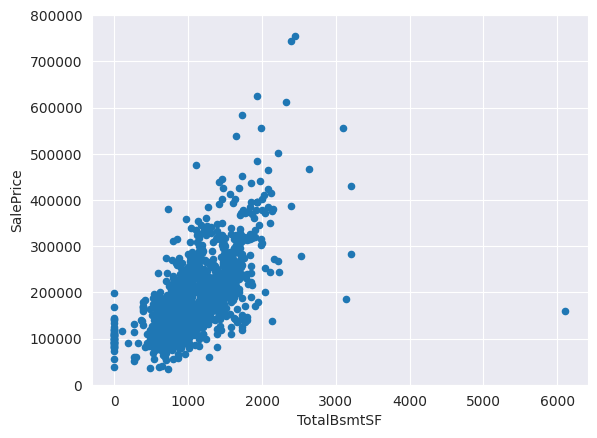

In [ ]:
#TotalBsmtSF：地下室の面積の合計平方フィート。
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

→Salepriceと強い線形(指数関数？)

##カテゴリ特徴量との関係

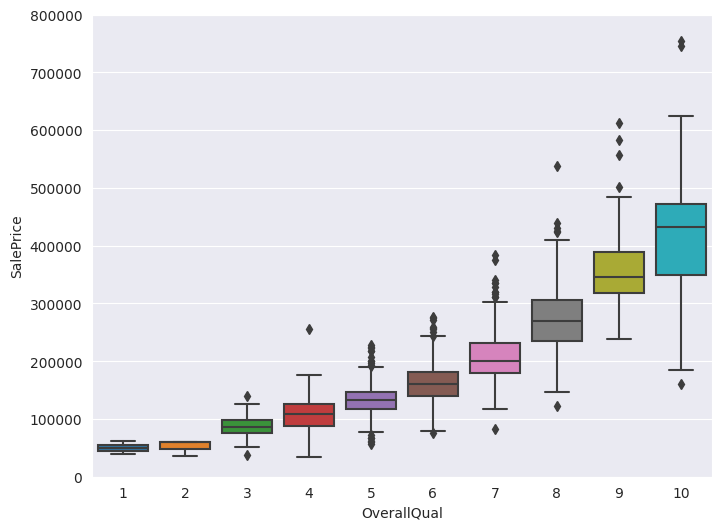

In [ ]:
#素材と仕上げの総合的な品質
var = 'OverallQual'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

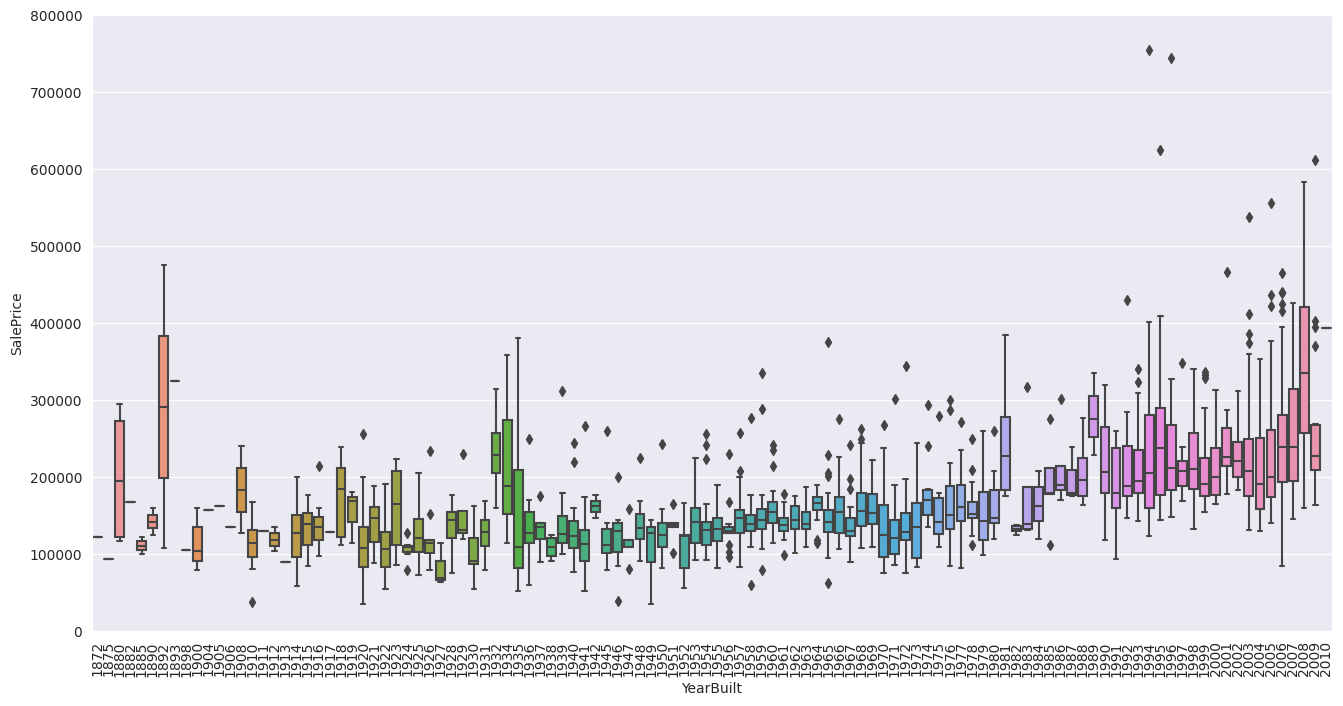

In [ ]:
#建設年
var = 'YearBuilt'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

強い傾向ではありませんが、'SalePrice'は古い遺物よりも新しいものにお金を使う傾向が強いと言えるでしょう。

注：'SalePrice'が定価であるかどうかはわかりません。定価はインフレの影響を取り除こうとするものです。もし、'SalePrice'が定価でないなら、定価にする必要があります。

要約すると、ストーリーはさておき、結論から言うと

GrLivArea」と「TotalBsmtSF」は「SalePrice」と直線的な関係にあるようです。どちらも正の関係で、一方の変数が増加すると他方の変数も増加することを意味します。特に「TotalBsmtSF」の場合、線形関係の傾きが大きいことがわかる。
OverallQual」と「YearBuilt」も「SalePrice」と関係があるようです。OverallQual」の場合は関係が強いようで、ボックスプロットでは、全体的な品質が高いほど販売価格が上昇する様子が示されています。
今、4つの変数を分析しましたが、他にも分析すべき変数がたくさんあります。ここでのコツは、正しい特徴の選択（特徴選択）であり、それらの間の複雑な関係の定義（特徴工学）ではないようです。

とはいえ、麦と籾を分けてみよう。

##客観的な分析

これまでは、直感に従って、重要だと思われる変数を分析していました。客観的な分析に努めたものの、出発点は主観的なものであったと言わざるを得ません。

私はエンジニアとして、このようなアプローチには違和感を覚えます。私の教育では、主観の風をものともしない鍛錬された精神を養うことが目的でした。それには理由があるんです。構造工学の分野で主観的であろうとすれば、物理学が物事を崩壊させるのを目の当たりにすることになるでしょう。傷つくこともある。

だから、惰性に打ち勝ち、より客観的な分析をしようというわけです。

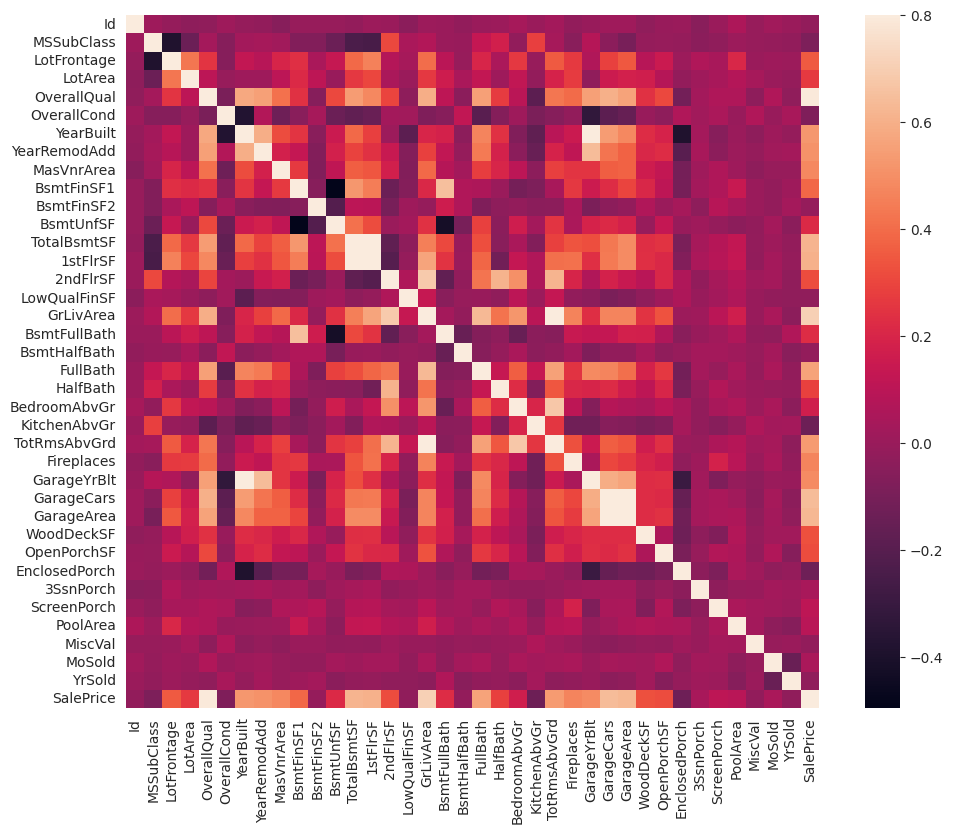

In [ ]:
#相関マトリックス（ヒートマップ形式）
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

①大きな相関

　1つ目は「TotalBsmtSF」と「1stFlrSF」

　2つ目は「GarageX」

→これらの変数はほとんど同じ情報を与えるので、多重共線性が発生していると結論。ヒートマップはこのような発見をするのに適しており、特徴選択に有効。

②SalePriceの相関関係

　「GrLivArea」、「TotalBsmtSF」、「OverallQual」以外にも考慮に入れるべき変数がたくさんある

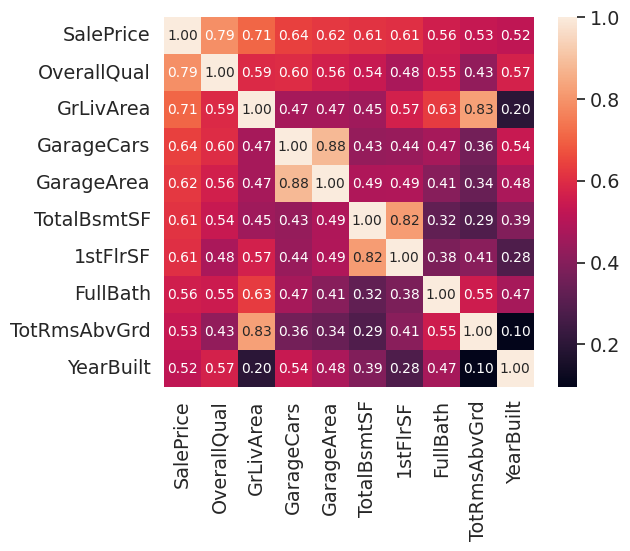

In [ ]:
#'SalePrice'の相関
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index #大きい方からk個
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

SalePriceとの相関関係

・「OverallQual」、「GrLivArea」、「TotalBsmtSF」は「SalePrice」はやはり強い相関。

・'GarageCars'と'GarageArea'も相関が強い変数の一つです。しかし、ガレージに収まる車の台数はガレージ面積の結果なので、「GarageCars」と「GarageArea」は1つだけ残せば良い（'SalePrice'との相関がより高いので、'GarageCars'を残すことができます）。

・TotalBsmtSF' と '1stFloor' もどちらかを残せば良いということで、「TotalBsmtSF」を残すことにします。

・「FullBath」？？

・「TotRmsAbvGrd」と「GrLivArea」もどちらかで良い

・「YearBuilt」は「SalePrice」と若干の相関があるようです。時系列分析でもした方がいいんじゃないかという気がしてくるので、これは宿題として残しておきます。




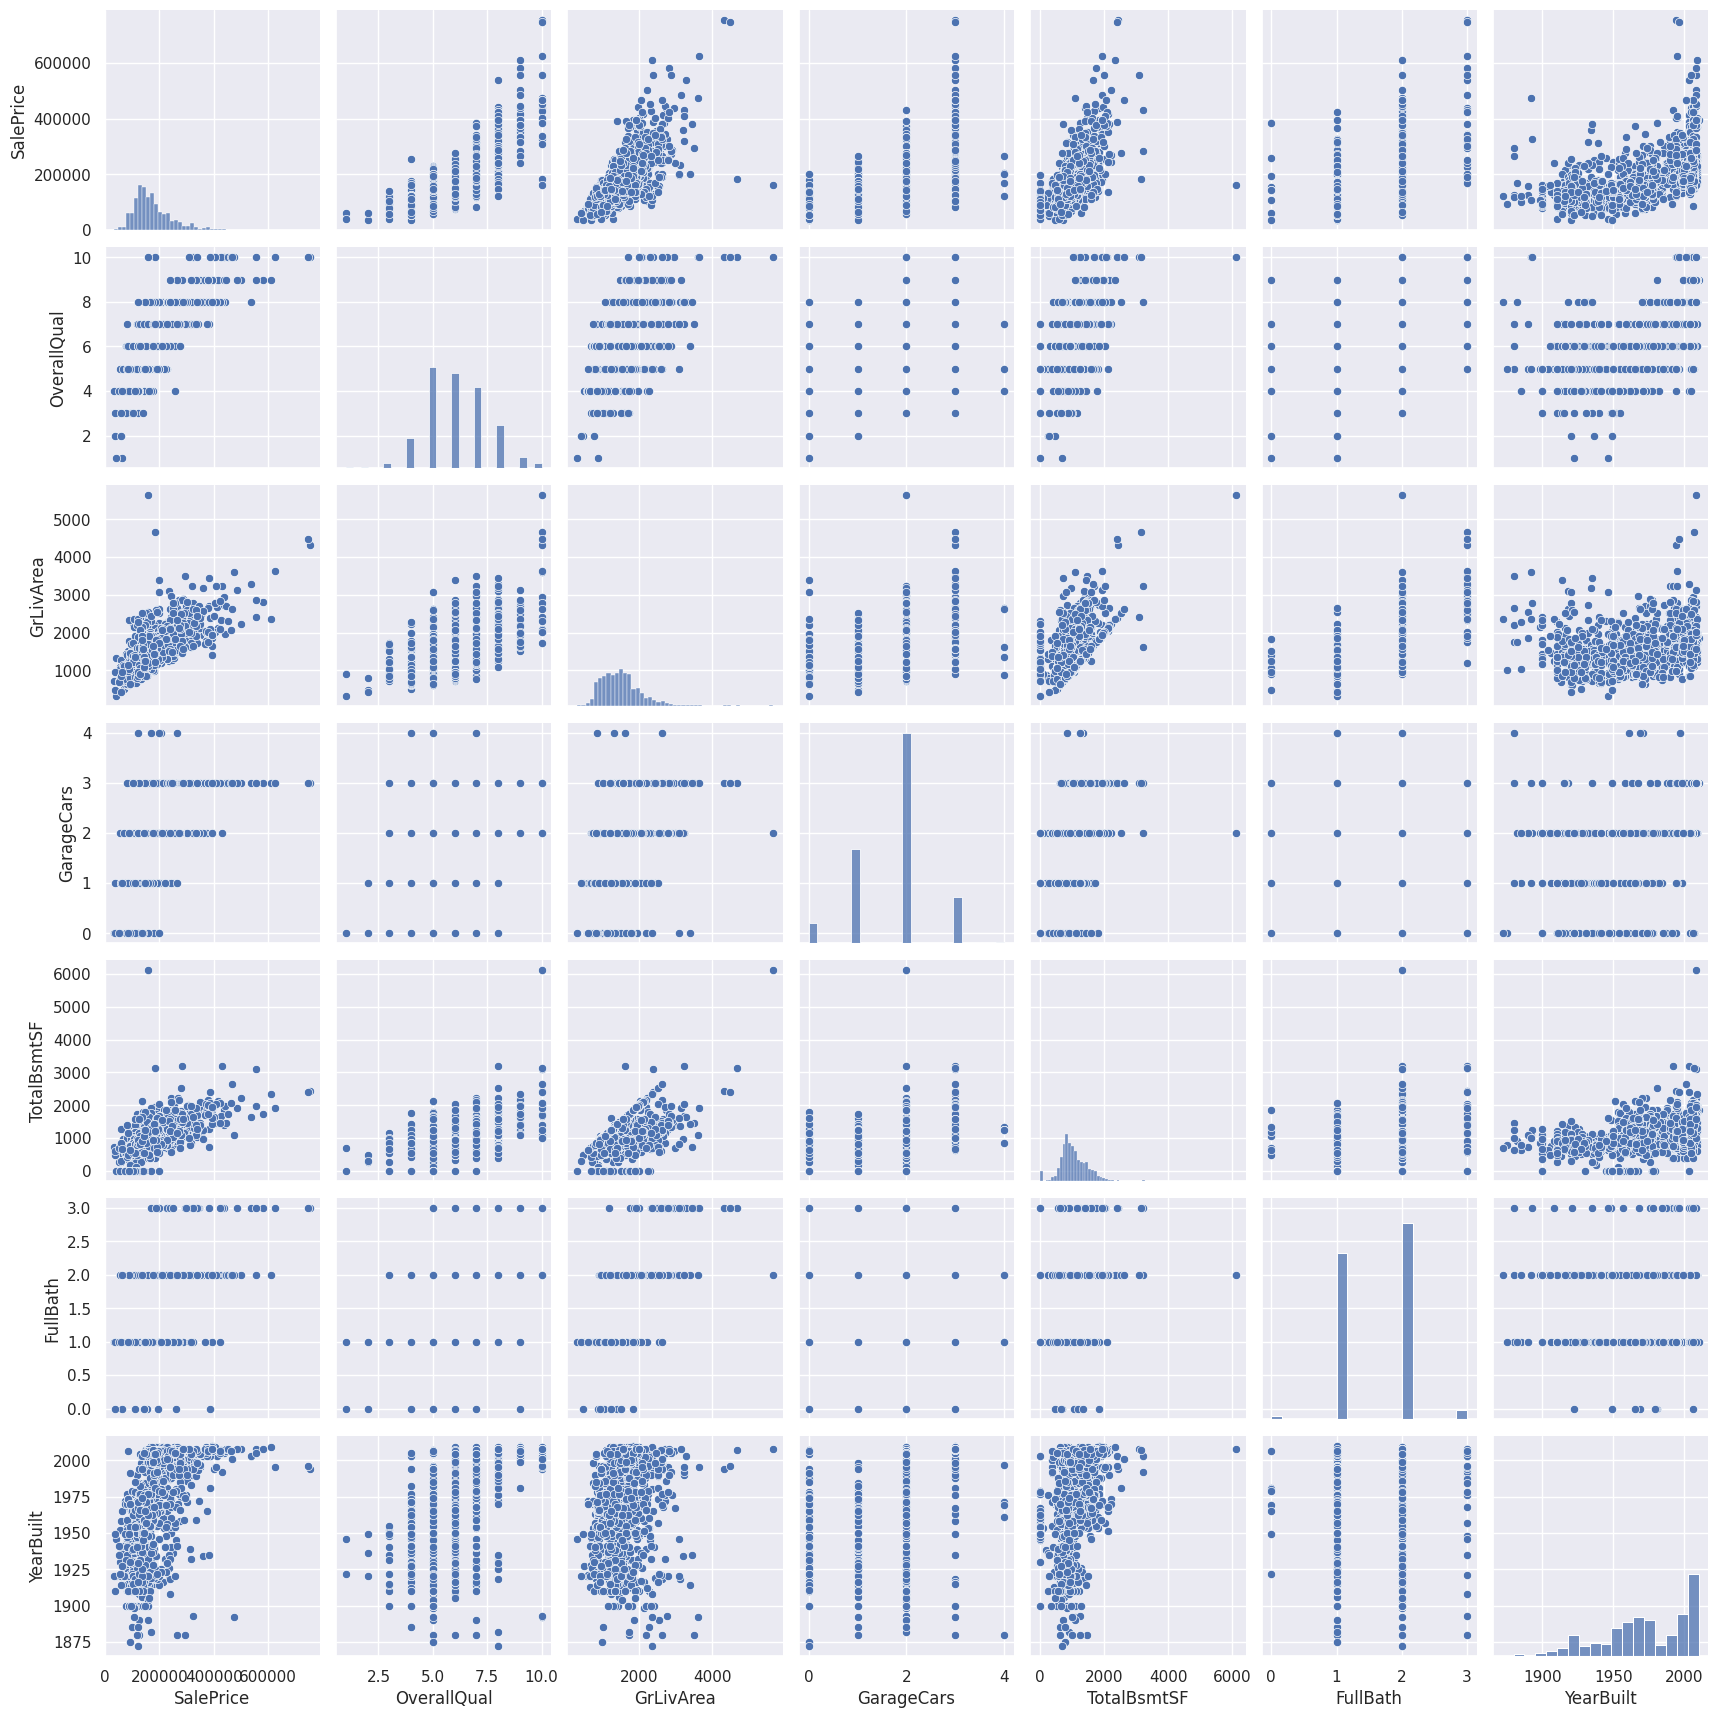

In [ ]:
#SalePriceと相関する変数の散布図
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], size = 2.5)
plt.show();

・「TotalBsmtSF」と「GrLiveArea」：直線的な線を描いており、それがほとんど境界線のように機能しているのがわかる。この線より下にドットが集中しているのは、理にかなっています。地下室の面積は地上部の居住面積と同じにすることができますが、地下室の面積が地上部の居住面積より大きくなることは想定されていません。

・「SalePrice」と「YearBuilt」に関するプロットも、考えさせられるものがある。点群」の底部には、ほとんど内気な指数関数に見えるものがある。また、「ドットクラウド」の上限にも、これと同じ傾向が見られる。また、ここ数年に関する点の集合が、この上限より上に留まる傾向があることに注目してください（価格がより速く上昇している）。

##欠損データの確認

欠損データはどの程度なのか？<br>
欠測はランダムなのか、それともパターンがあるのか？<br>
これらの質問に対する答えは、実用的な理由から重要です。<br>なぜなら、欠損データはサンプルサイズの減少を意味するからです。<br>このため、分析を進めることができなくなる可能性があります。<br>さらに、実質的な観点からは、欠損データの処理に偏りがなく、不都合な真実が隠されていないことを確認する必要があります。

In [ ]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995
MiscFeature,1406,0.963
Alley,1369,0.938
Fence,1179,0.808
FireplaceQu,690,0.473
LotFrontage,259,0.177
GarageYrBlt,81,0.055
GarageCond,81,0.055
GarageType,81,0.055
GarageFinish,81,0.055


欠損データの扱い方

・データの15％以上が欠損している場合、該当する変数を削除して、存在しなかったことにすることを考えます。つまり、このような場合、欠損データを埋めるためのトリックは一切試さないということです。これによると、削除すべき変数（'PoolQC'、'MiscFeature'、'Alley'など）がある。これらの変数のほとんどは、私たちが家を買うときに考えるようなものではない（もしかしたら、それがデータが欠落する理由かもしれませんね）。さらに、変数をよく見ると、「PoolQC」、「MiscFeature」、「FireplaceQu」のような変数は、外れ値の有力な候補と言えるので、削除してしまってもよいだろう。

・残りのケースについてですが、'GarageX'の変数が同じ数の欠損データを持っていることがわかります。欠損データが同じオブザベーションのセットであることは間違いないでしょう（5%のために確認の時間を費やさない）ガレージに関する最も重要な情報は 'GarageCars' で表現されているので、5%の欠損データについて話しているだけであることを考慮して、言及した 'GarageX' 変数を削除することにします。

・'BsmtX' 変数も同様。

・MasVnrArea'と'MasVnrType'については、これらの変数は必須ではないと考える。さらに、これらの変数は、'YearBuilt' および 'OverallQual' と強い相関がある。したがって、'MasVnrArea'と'MasVnrType'を削除しても、情報を失うことはない。

・'Electrical'に1つの欠落したオブザベーションがあります。たった1つのオブザベーションなので、このオブザベーションを削除して、変数を維持することにします。

要約すると、欠損データを処理するために、変数 'Electrical' を除いて、欠損データを持つすべての変数を削除します。Electrical'では、欠損データのあるオブザベーションを削除するだけです。

In [ ]:
df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index,1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
df_train.isnull().sum().max()

0

##外れ値
外れ値はモデルに大きな影響を与え、特定の行動に関する洞察を与えてくれる貴重な情報源となり得る。

「SalePrice」の標準偏差と散布図を通して、簡単な分析を行う

###単変量解析
ここでの主な関心事は、ある観測値を異常値として定義する閾値を設定することです。そのために、データを標準化します。この文脈では、データの標準化とは、データ値を平均値0、標準偏差1に変換することを意味します。

In [ ]:
saleprice_scaled = StandardScaler().fit_transform(df_train['SalePrice'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]

outer range (high) of the distribution:
[[3.82758058]
 [4.0395221 ]
 [4.49473628]
 [4.70872962]
 [4.728631  ]
 [5.06034585]
 [5.42191907]
 [5.58987866]
 [7.10041987]
 [7.22629831]]


低レンジの値は似ていて、0からそれほど離れていない。<br>
高域の値は0から遠く、7.xxの値は本当に範囲外である。
今のところ、どの値も外れ値とは見なさないが、この2つの7.xxの値には注意が必要である。(二変量分析に持ち越し)

###二変量解析

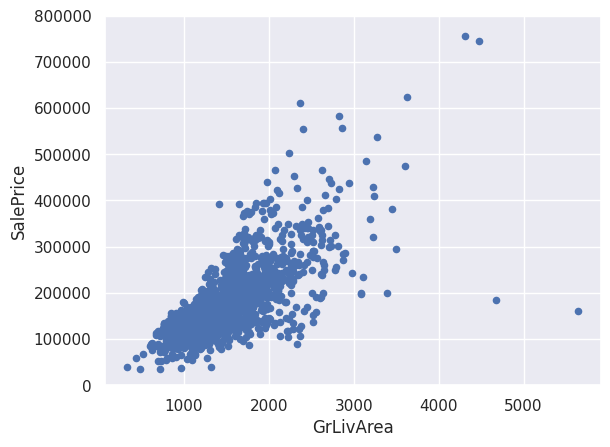

In [ ]:
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

・「GrLivArea」が大きい2つの値は奇妙に見える。なぜこのようなことが起きているのか、推測することができます。もしかしたら、農地面積を指しているのかもしれませんし、それで低価格を説明できるかもしれません。しかし、この2点は典型的なケースを代表するものではないという確信があります。したがって、これらを外れ値として定義し、削除することにします。<br>
・プロットの上部にある2つのオブザベーションは、我々が注意すべきと言った7.xxオブザベーションです。それらは、2つの特別なケースのように見えますが、トレンドに従っているようです。そのため、それらを保持することにします。

In [ ]:
df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)

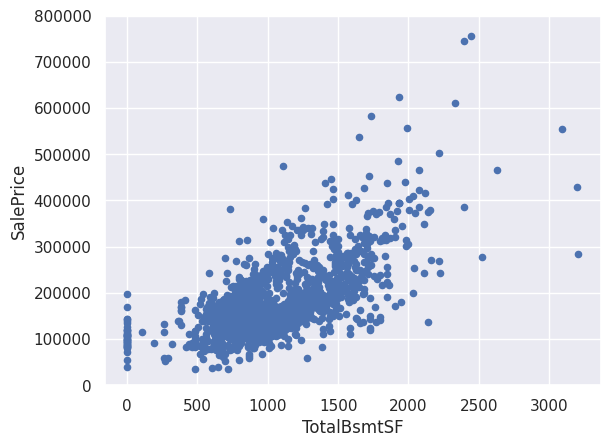

In [ ]:
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

いくつかの観測結果（例えば、TotalBsmtSF > 3000）を排除したい気持ちになることもありますが、その価値はないでしょう。

##「SalePrice」とは何なのか？

この問いに対する答えは、多変量解析の統計的根拠の前提条件を検証することにある。私たちはすでにデータクリーニングを行い、『SalePrice』について多くのことを発見しました。今度は、「SalePrice」が多変量解析の手法を適用するための統計的前提にどのように適合しているかを深く理解する番です。

正規性 - データが正規分布のように見えるかです。これは、いくつかの統計的検定がこれに依存しているため重要です（例えば、t統計）。この演習では、「SalePrice」の一変量正規性をチェックするだけです（これは限定的なアプローチです）。一変量正規性は、多変量正規性（これは我々が望むものです）を保証するものではありませんが、助けになることを忘れないでください。考慮すべきもう1つの詳細は、大きなサンプル（200以上のオブザベーション）では、正規性はそれほど問題ではないことです。しかし、正規性を解決すれば、他の多くの問題（たとえば、ヘテロ分散性）を避けることができるので、それがこの分析を行っている主な理由です。

ホモセディシティ-「従属変数が予測変数の範囲にわたって等しいレベルの分散を示すという仮定」(Hair et al., 2013)を指します。独立変数のすべての値で誤差項が同じであることを望む。

線形性- 線形性を評価する最も一般的な方法は、散布図を調べ、線形パターンを探すことである。もしパターンが直線的でない場合は、データの変換を検討する価値がある。しかし、私たちが見た散布図のほとんどは直線的な関係を持っているように見えるので、この点については触れないことにします。

相関性のあるエラーの欠如 - あるエラーが他のエラーと相関している場合に起こります。例えば、ある正の誤差が系統的に負の誤差を生む場合、これらの変数の間に関係があることを意味します。これは時系列でよく起こることで、あるパターンが時間的に関連しているということです。また、これには触れないことにします。しかし、何かを検出したら、その効果を説明できるような変数を追加してみる。それが相関誤差の最も一般的な解決策です。

###正規性：ヒストグラム - 尖度と歪度。
正規確率プロット - データの分布は、正規分布を表す対角線に忠実に従うべきである。

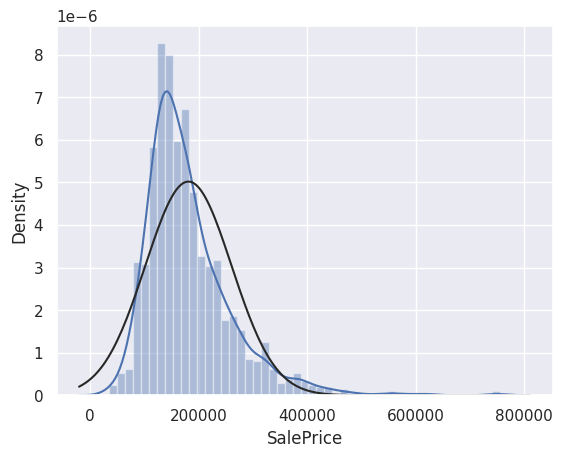

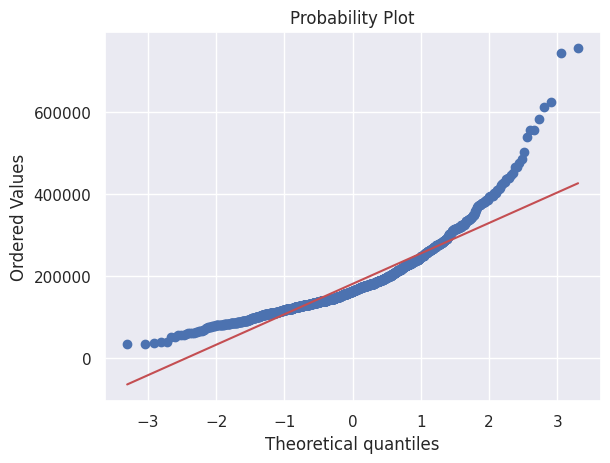

In [ ]:
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

正規ではない：「ピーク性」、「正の歪度」を示し、対角線に沿わない。

しかし、すべてが失われたわけではありません。簡単なデータ変換で問題を解決することができます。これは統計の本で学べる素晴らしいことのひとつで、正の歪度の場合、通常は対数変換がうまくいくのです。

In [ ]:
df_train['SalePrice'] = np.log(df_train['SalePrice'])

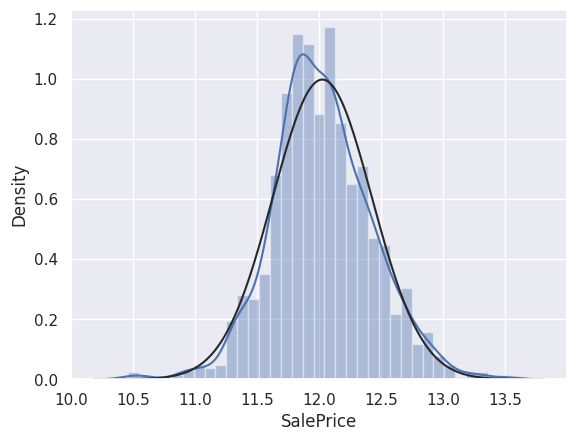

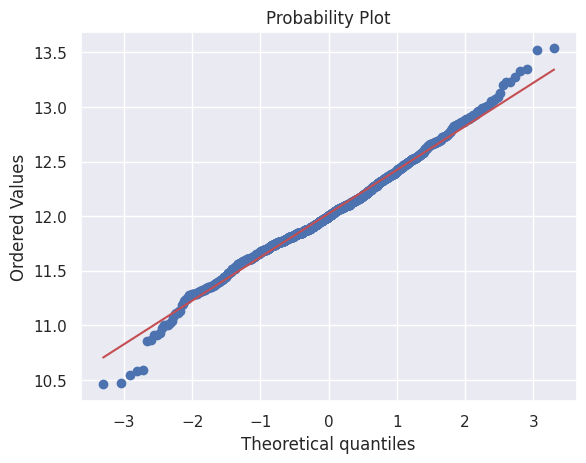

In [ ]:
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

GrLivArea

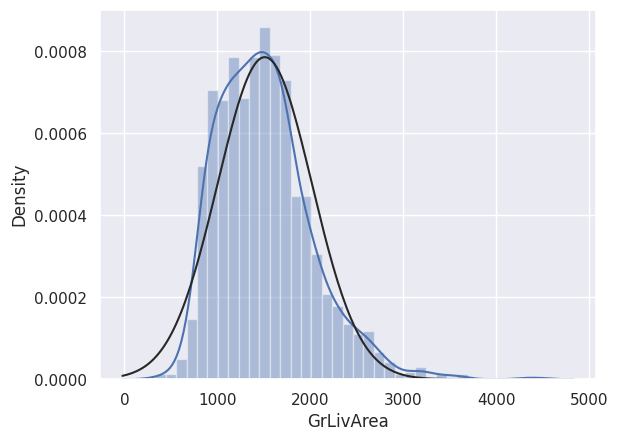

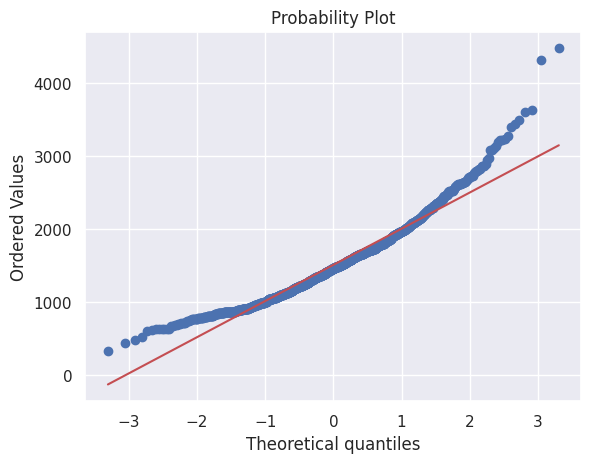

In [ ]:
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

対数変換

In [ ]:
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])

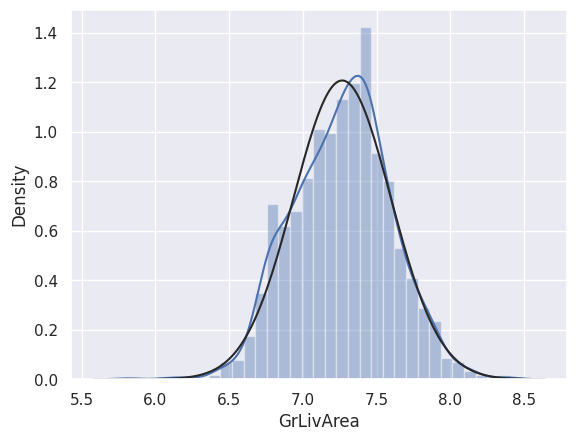

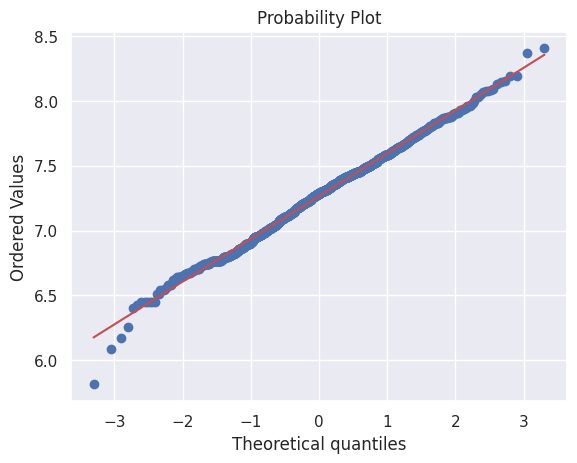

In [ ]:
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

TotalBsmtSF

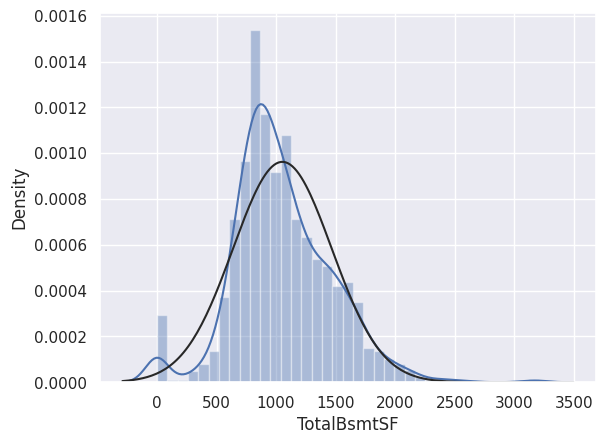

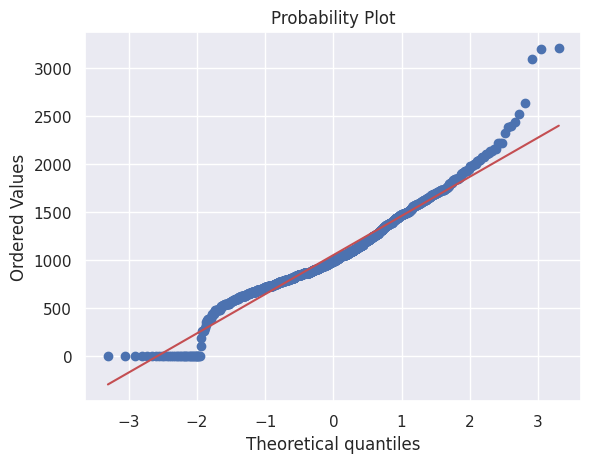

In [ ]:
sns.distplot(df_train['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['TotalBsmtSF'], plot=plt)

値ゼロのオブザベーションがかなり多い（地下室のない家）。値ゼロは、対数変換を行うことを許さないので、大きな問題です。<br>
ここで対数変換を適用するために、地下室があるかないかの効果を得ることができる変数（2値変数）を作成します。そして、値が0であるオブザベーションを無視して、0でないオブザベーションすべてに対数変換を行うことにします。こうすることで、地下室の有無の効果を失わずに、データを変換することができます。


In [ ]:
#if area>0 it gets 1, for area==0 it gets 0
df_train['HasBsmt'] = pd.Series(len(df_train['TotalBsmtSF']), index=df_train.index)
df_train['HasBsmt'] = 0
df_train.loc[df_train['TotalBsmtSF']>0,'HasBsmt'] = 1

対数変換

In [ ]:
df_train.loc[df_train['HasBsmt']==1,'TotalBsmtSF'] = np.log(df_train['TotalBsmtSF'])

/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

divide by zero encountered in log



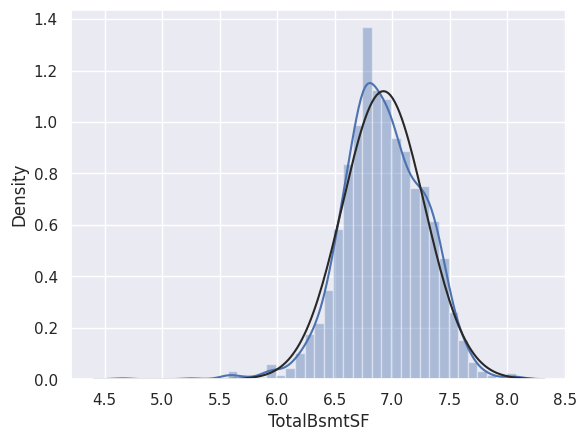

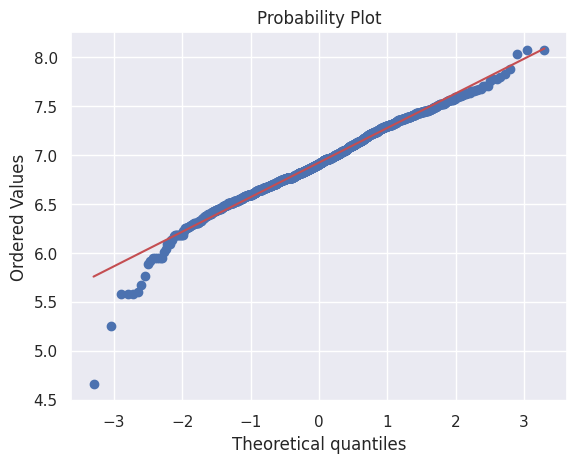

In [ ]:
sns.distplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

###ホモセンシディシティ
均等分散からの逸脱は、円錐（グラフの片側で小さな分散、反対側で大きな分散）または菱形（分布の中心で多数の点）のような形状

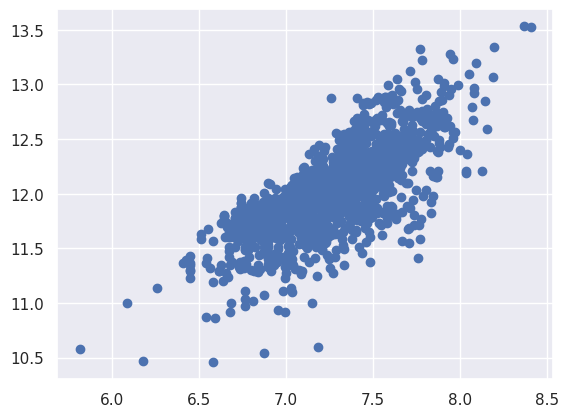

In [ ]:
# 'SalePrice' with 'GrLivArea'
plt.scatter(df_train['GrLivArea'], df_train['SalePrice']);

この散布図の古いバージョン（対数変換前）は、円錐形をしていました（戻って「SalePrice」と相関変数の散布図（move like Jagger style）」を確認してください）。ご覧のように、現在の散布図にはもう円錐形はありません。これが正規性の威力です！一部の変数で正規性を確保するだけで、均等分散性の問題が解決したのです。

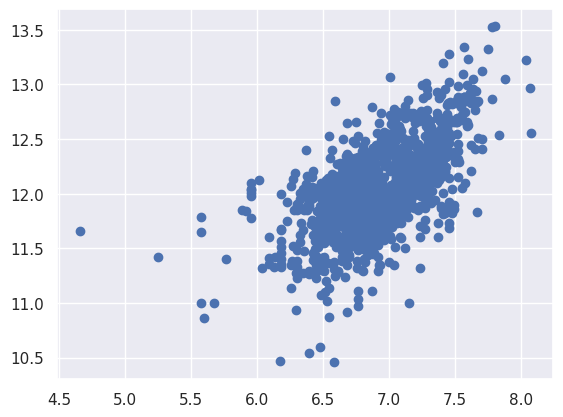

In [ ]:
#'SalePrice' with 'TotalBsmtSF'
plt.scatter(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], df_train[df_train['TotalBsmtSF']>0]['SalePrice']);

一般に、「SalePrice」は「TotalBsmtSF」の範囲内で同じレベルの分散を示すと言える。

##ダミー変数

In [ ]:
df_train = pd.get_dummies(df_train)

##モデル

In [ ]:
val_y_train = df_train.SalePrice.values
df_train.drop(['SalePrice'], axis=1, inplace=True)

In [ ]:
n_folds = 5

def rmsle_cv2(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(df_train.values)
    # 各フォールドでモデルを訓練し、残りのフォールドで予測を行い、MSE を算出
    # 各フォールドの MSE の平均値の平方根 (RMSE) を返します。
    # 目的変数の値を対数変換しているため、評価指標には RMSLE (Root Mean Squared Logarithmic Error) が使用されます。
    rmse= np.sqrt(-cross_val_score(model, df_train.values, val_y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [ ]:
score = rmsle_cv2(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1116 (0.0066)



In [ ]:
score = rmsle_cv2(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1116 (0.0067)



In [ ]:
score = rmsle_cv2(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning:

Ill-conditioned matrix (rcond=3.89498e-19): result may not be accurate.

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning:

Ill-conditioned matrix (rcond=1.32898e-18): result may not be accurate.

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning:

Ill-conditioned matrix (rcond=4.76004e-19): result may not be accurate.

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning:

Ill-conditioned matrix (rcond=3.85145e-19): result may not be accurate.



Kernel Ridge score: 1.1963 (0.8833)



/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning:

Ill-conditioned matrix (rcond=4.06057e-19): result may not be accurate.



In [ ]:
score = rmsle_cv2(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1167 (0.0079)



In [ ]:
model_xgb2 = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,
                             learning_rate=0.05, max_depth=3,
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
score = rmsle_cv2(model_xgb2)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[00:06:51] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[00:06:58] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[00:07:06] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[00:07:14] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[00:07:22] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

Xgboost score: 0.1166 (0.0065)



In [ ]:
model_lgb2 = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
score = rmsle_cv2(model_lgb2)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6

In [ ]:
averaged_models = AveragingModels(models = (ENet, GBoost, lasso))
score = rmsle_cv2(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1081 (0.0070)



In [ ]:
#Enet KRRとGboostを平均化し、メタモデルとしてlassoを追加しています。
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost),
                                                 meta_model = lasso)
score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1081 (0.0073)


##予測

In [ ]:
df_test = pd.read_csv(opt.input_dir + "train.csv")

In [ ]:
total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995
MiscFeature,1406,0.963
Alley,1369,0.938
Fence,1179,0.808
FireplaceQu,690,0.473
LotFrontage,259,0.177
GarageYrBlt,81,0.055
GarageCond,81,0.055
GarageType,81,0.055
GarageFinish,81,0.055


In [ ]:
df_test = df_test.drop((missing_data[missing_data['Total'] > 1]).index,1)
df_test = df_test.drop(df_test.loc[df_test['Electrical'].isnull()].index)
df_test.isnull().sum().max()

df_test['GrLivArea'] = np.log(df_test['GrLivArea'])

#if area>0 it gets 1, for area==0 it gets 0
df_test['HasBsmt'] = pd.Series(len(df_test['TotalBsmtSF']), index=df_test.index)
df_test['HasBsmt'] = 0
df_test.loc[df_test['TotalBsmtSF']>0,'HasBsmt'] = 1
df_test.loc[df_test['HasBsmt']==1,'TotalBsmtSF'] = np.log(df_test['TotalBsmtSF'])

df_test = pd.get_dummies(df_test)

/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

divide by zero encountered in log



In [ ]:
df_train.columns.values

array(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
       'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'HasBsmt',
       'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL',
       'MSZoning_RM', 'Street_Grvl', 'Street_Pave', 'LotShape_IR1',
       'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_Bnk',
       'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl',
       'Utilities_AllPub', 'Utilities_NoSeWa', 'LotConfig_Corner',
       'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3',
       'LotConfig_Inside', 'LandSlope_Gtl', 'LandSlope_Mod',
   

In [ ]:
df_test.columns.values

array(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
       'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'HasBsmt',
       'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL',
       'MSZoning_RM', 'Street_Grvl', 'Street_Pave', 'LotShape_IR1',
       'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_Bnk',
       'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl',
       'Utilities_AllPub', 'Utilities_NoSeWa', 'LotConfig_Corner',
       'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3',
       'LotConfig_Inside', 'LandSlope_Gtl', 'LandSl

In [ ]:
df_train.head()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,8450,7,5,2003,2003,706,0,150,...,0,0,0,1,0,0,0,0,1,0
1,2,20,9600,6,8,1976,1976,978,0,284,...,0,0,0,1,0,0,0,0,1,0
2,3,60,11250,7,5,2001,2002,486,0,434,...,0,0,0,1,0,0,0,0,1,0
3,4,70,9550,7,5,1915,1970,216,0,540,...,0,0,0,1,1,0,0,0,0,0
4,5,60,14260,8,5,2000,2000,655,0,490,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
df_test.drop(['SalePrice'], axis=1, inplace=True)
df_test.drop(['RoofMatl_ClyTile'], axis=1, inplace=True)

In [ ]:
# 実際の値と予測値の両方を対数変換した上で、平均二乗誤差（MSE）を計算し、その平方根を返す関数です。
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [ ]:
stacked_averaged_models.fit(df_train.values, val_y_train)
stacked_train_pred = stacked_averaged_models.predict(df_train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(df_test.values))
print(rmsle(val_y_train, stacked_train_pred))

0.08043538773387499


In [ ]:
model_xgb2.fit(df_train, val_y_train)
xgb_train_pred2 = model_xgb2.predict(df_train)
xgb_pred2 = np.expm1(model_xgb2.predict(df_test))
print(rmsle(val_y_train, xgb_train_pred2))

[00:46:35] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

0.08007638077642926


In [ ]:
model_lgb2.fit(df_train, val_y_train)
lgb_train_pred2 = model_lgb2.predict(df_train)
lgb_pred2 = np.expm1(model_lgb2.predict(df_test.values))
print(rmsle(val_y_train, lgb_train_pred2))

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
0.07495427909815763


In [ ]:
print('RMSLE score on train data:')
print(rmsle(val_y_train, stacked_train_pred*0.70 + xgb_train_pred2*0.15 + lgb_train_pred2*0.15 ))

RMSLE score on train data:
0.07758832107480519


In [ ]:
ensemble = stacked_pred*0.70 + xgb_pred2*0.15 + lgb_pred2*0.15

In [ ]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv(opt.input_dir + 'submission.csv',index=False)